In [1]:
import numpy as np, pandas as pd
import joblib, os
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("ticks")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2
from scripts import farseeing, classifiers, utils

In [ ]:
# mobilised_acc_t1 = pd.read_csv('data/mobilised/10073-acc-T1-MM-25052021.csv')
# mobilised_acc_t2 = pd.read_csv('data/mobilised/10073-acc-T2-MM-24112021.csv')
# mobilised_acc_t3 = pd.read_csv('data/mobilised/10073-acc-T3-MM-24052022.csv')
# mobilised_acc_t4 = pd.read_csv('data/mobilised/10073-acc-T4-MM-22112022.csv')

In [64]:
acc_data = pd.read_csv('data/mobilised/10073-acc-T1-MM-25052021.csv')
acc_data['accel_mag'] = utils.magnitude(
    np.clip(acc_data.iloc[:,1:4], -2, 2))
acc_data['time'] = pd.to_datetime(acc_data['time'], unit='s')
acc_data = acc_data.set_index('time')

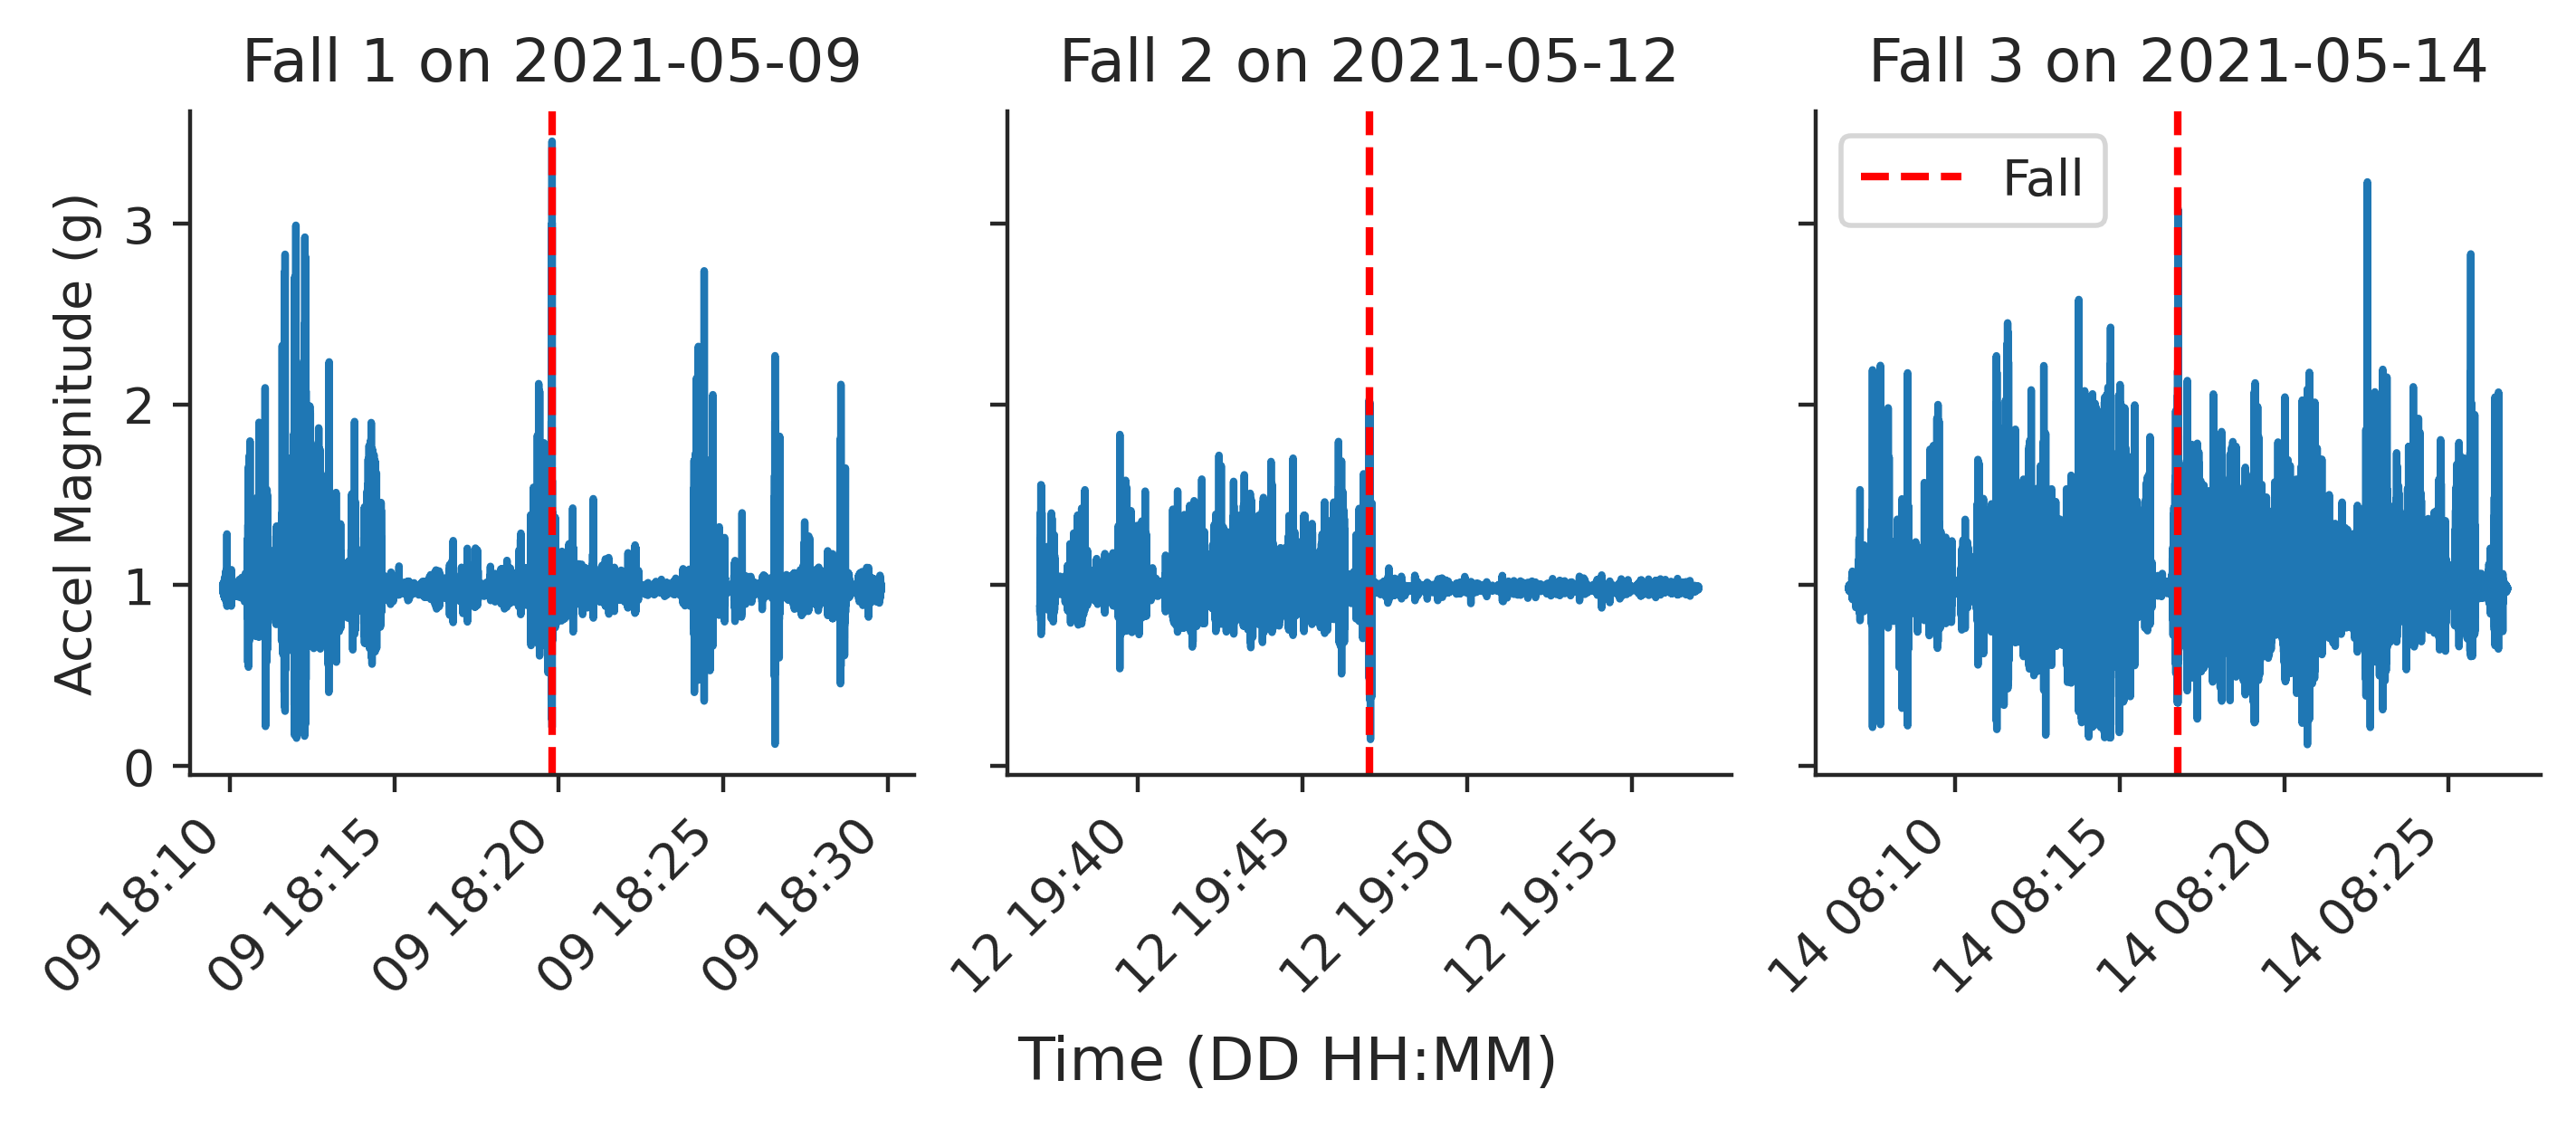

In [65]:
# Fall 1, May 9th 2021 at 18:19:47.504 on Day 2
fall_hour1 = acc_data.loc['2021-05-09 18:09:47':'2021-05-09 18:29:47']
fall_hour2 = acc_data.loc['2021-05-12 19:37:01':'2021-05-12 19:57:01']
fall_hour3 = acc_data.loc['2021-05-14 08:06:46':'2021-05-14 08:26:46']
fall_locs = [pd.to_datetime('2021-05-09 18:19:47.504'),
			 pd.to_datetime('2021-05-12 19:47:01.184'),
			 pd.to_datetime('2021-05-14 08:16:46.374')]
fig, axs = plt.subplots(1, 3, figsize=(7, 3), sharey=True,
						layout='constrained', dpi=400)
for i, fall_hour in enumerate([fall_hour1, fall_hour2, fall_hour3]):
	axs[i].plot(fall_hour.index, fall_hour['accel_mag'])
	axs[i].set_title(f'Fall {i+1} on {fall_locs[i].date()}')
	# annotate the falls
	axs[i].axvline(fall_locs[i], color='r', linestyle='--', label='Fall')
	# rotate and align the tick labels so they look better
	plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
axs[0].set_ylabel('Accel Magnitude (g)')
axs[2].legend()
fig.supxlabel('Time (DD HH:MM)')
sns.despine()
plt.savefig('figs/mobilised_falls.pdf',
			bbox_inches='tight', dpi=400)
plt.show()

In [73]:
kwargs = dict(
	window_size=28,
    split=False,
	multiphase=True,
    plot = True,
	tolerance=160,
)
# if kwargs['saved_models'] is None:
X, y = utils.train_test_subjects_split(farseeing, **kwargs)

#### Testing on FARSEEING ADLs

In [91]:
# Mobilise-D falls
fall_hour1 = acc_data.loc['2021-05-09 18:09:00':'2021-05-09 18:29:00']
fall_hour2 = acc_data.loc['2021-05-12 19:37:00':'2021-05-12 19:57:00']
fall_hour3 = acc_data.loc['2021-05-14 08:06:00':'2021-05-14 08:26:00']
X_test_mobilised = [list(fall_hour1['accel_mag'].values),
		  list(fall_hour2['accel_mag'].values),
		  list(fall_hour3['accel_mag'].values)]

y_test_mobilised = [fall_hour1.index.get_loc('2021-05-09 18:19:47.504').start,
          fall_hour2.index.get_loc('2021-05-12 19:47:01.184').start,
		  fall_hour3.index.get_loc('2021-05-14 08:16:46.374').start]

# Ataxia, PSP and Rehab ADLs
cols = ['Acc AP', 'Acc ML', 'Acc V']
ataxia_df = pd.read_csv('data/adls/subAtaxia5_3.csv', usecols=cols)
ataxia_df['accel_mag'] = utils.magnitude(np.clip(ataxia_df.iloc[:,0:3], -2, 2))
psp_df = pd.read_csv('data/adls/subPSP5_4.csv', usecols=cols)
psp_df['accel_mag'] = utils.magnitude(np.clip(psp_df.iloc[:,0:3], -2, 2))
rehab_df = pd.read_csv('data/adls/subRehab1_1.csv', usecols=cols)
rehab_df['accel_mag'] = utils.magnitude(np.clip(rehab_df.iloc[:,0:3], -2, 2))
	
X_test_farseeing_adl = [
    list(ataxia_df['accel_mag'].values),
	list(psp_df['accel_mag'].values),
	list(rehab_df['accel_mag'].values)]
y_test_farseeing_adl = [-1, -1, -1] # No falls in these ADLs

# Comnine all test data
X_test = X_test_mobilised + X_test_farseeing_adl
y_test = y_test_mobilised + y_test_farseeing_adl

In [74]:
kwargs['models_subset'] = ['QUANT']
trained_quant, thresh = classifiers.train_models(X, y, **kwargs)
joblib.dump({'models': trained_quant,
             'thresholds': thresh},
             'models/full_farseeing_trained_quant_w40_t160.joblib')

⏳ TRAINING QUANT. ✅


['models/full_farseeing_trained_quant_w40_t160.joblib']

Loaded models
🔍 TESTING QUANT

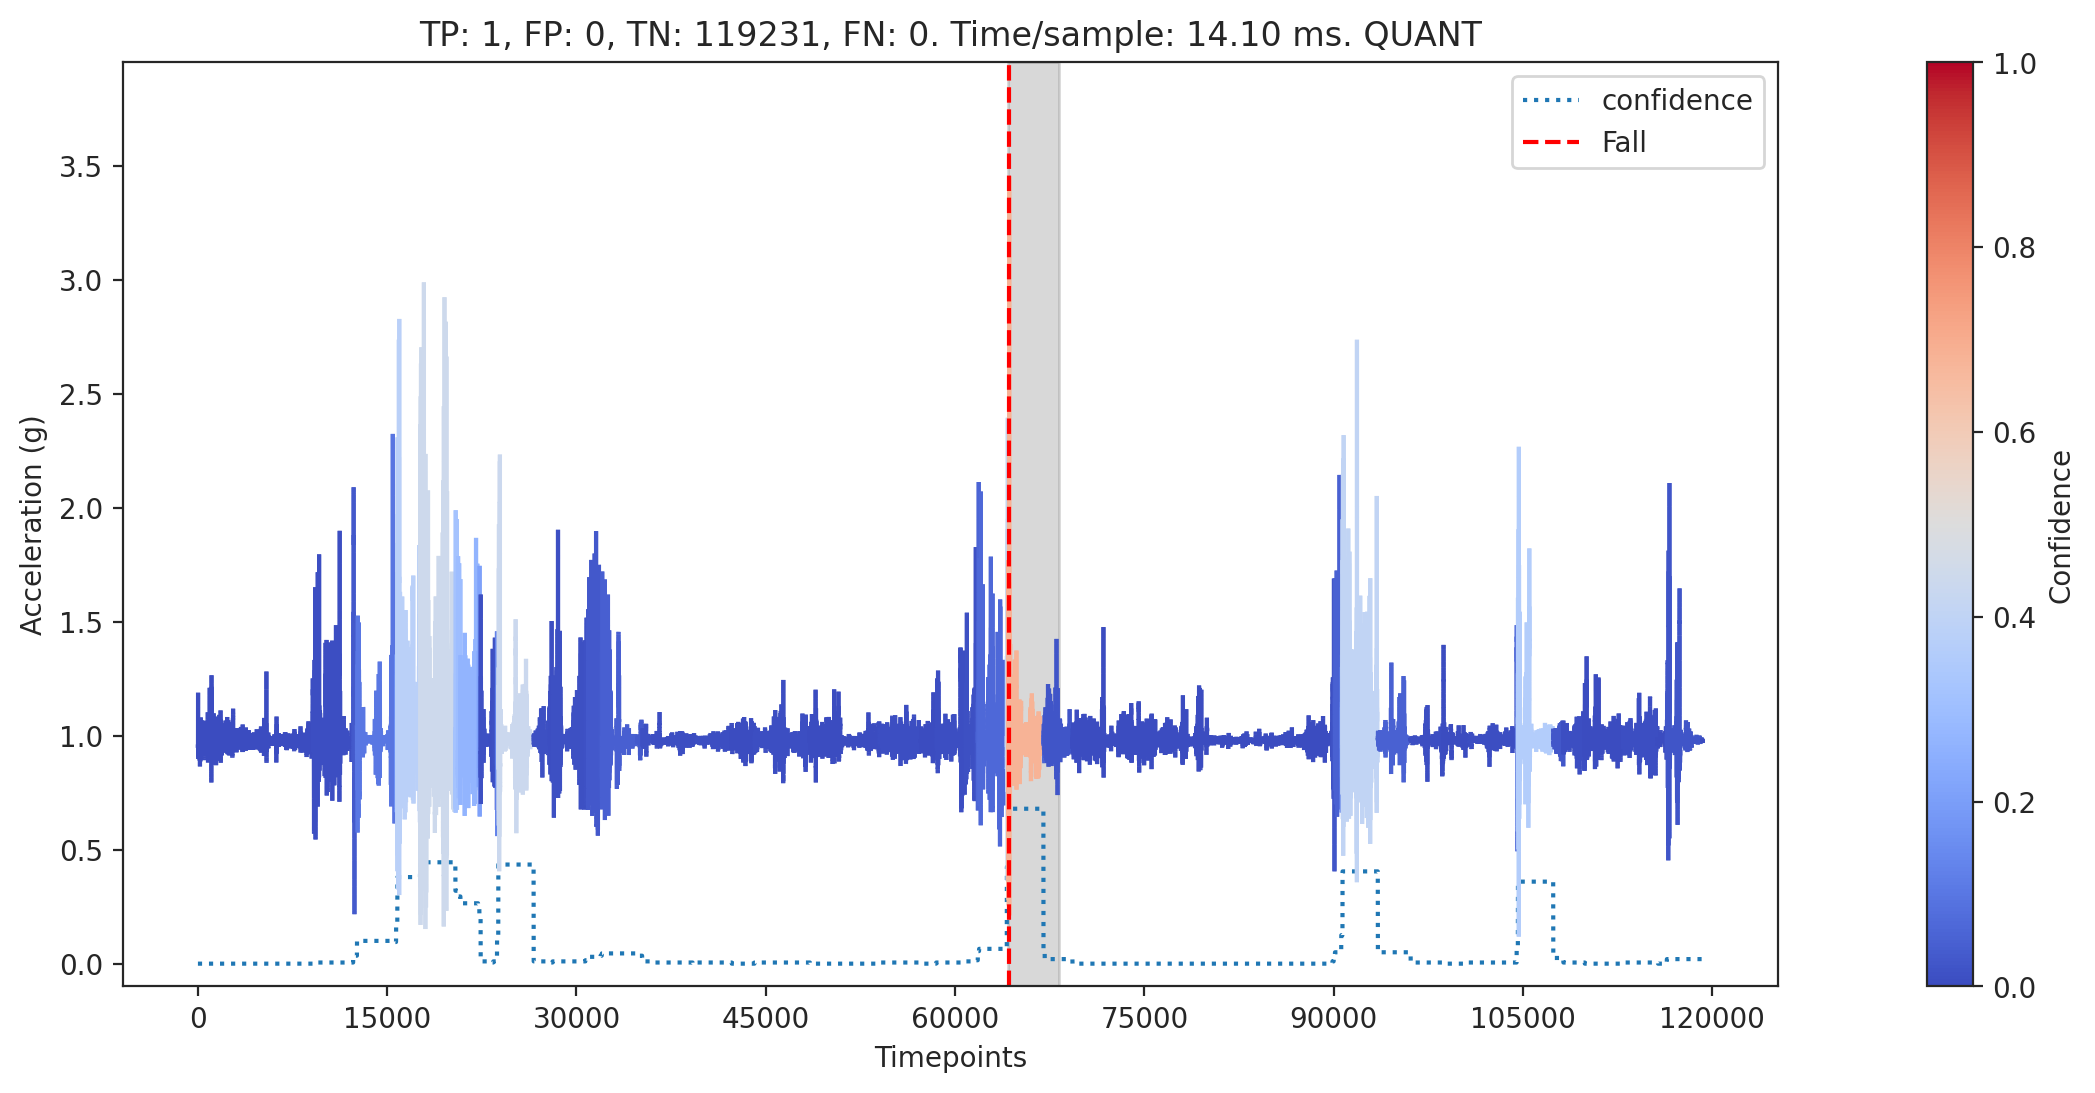

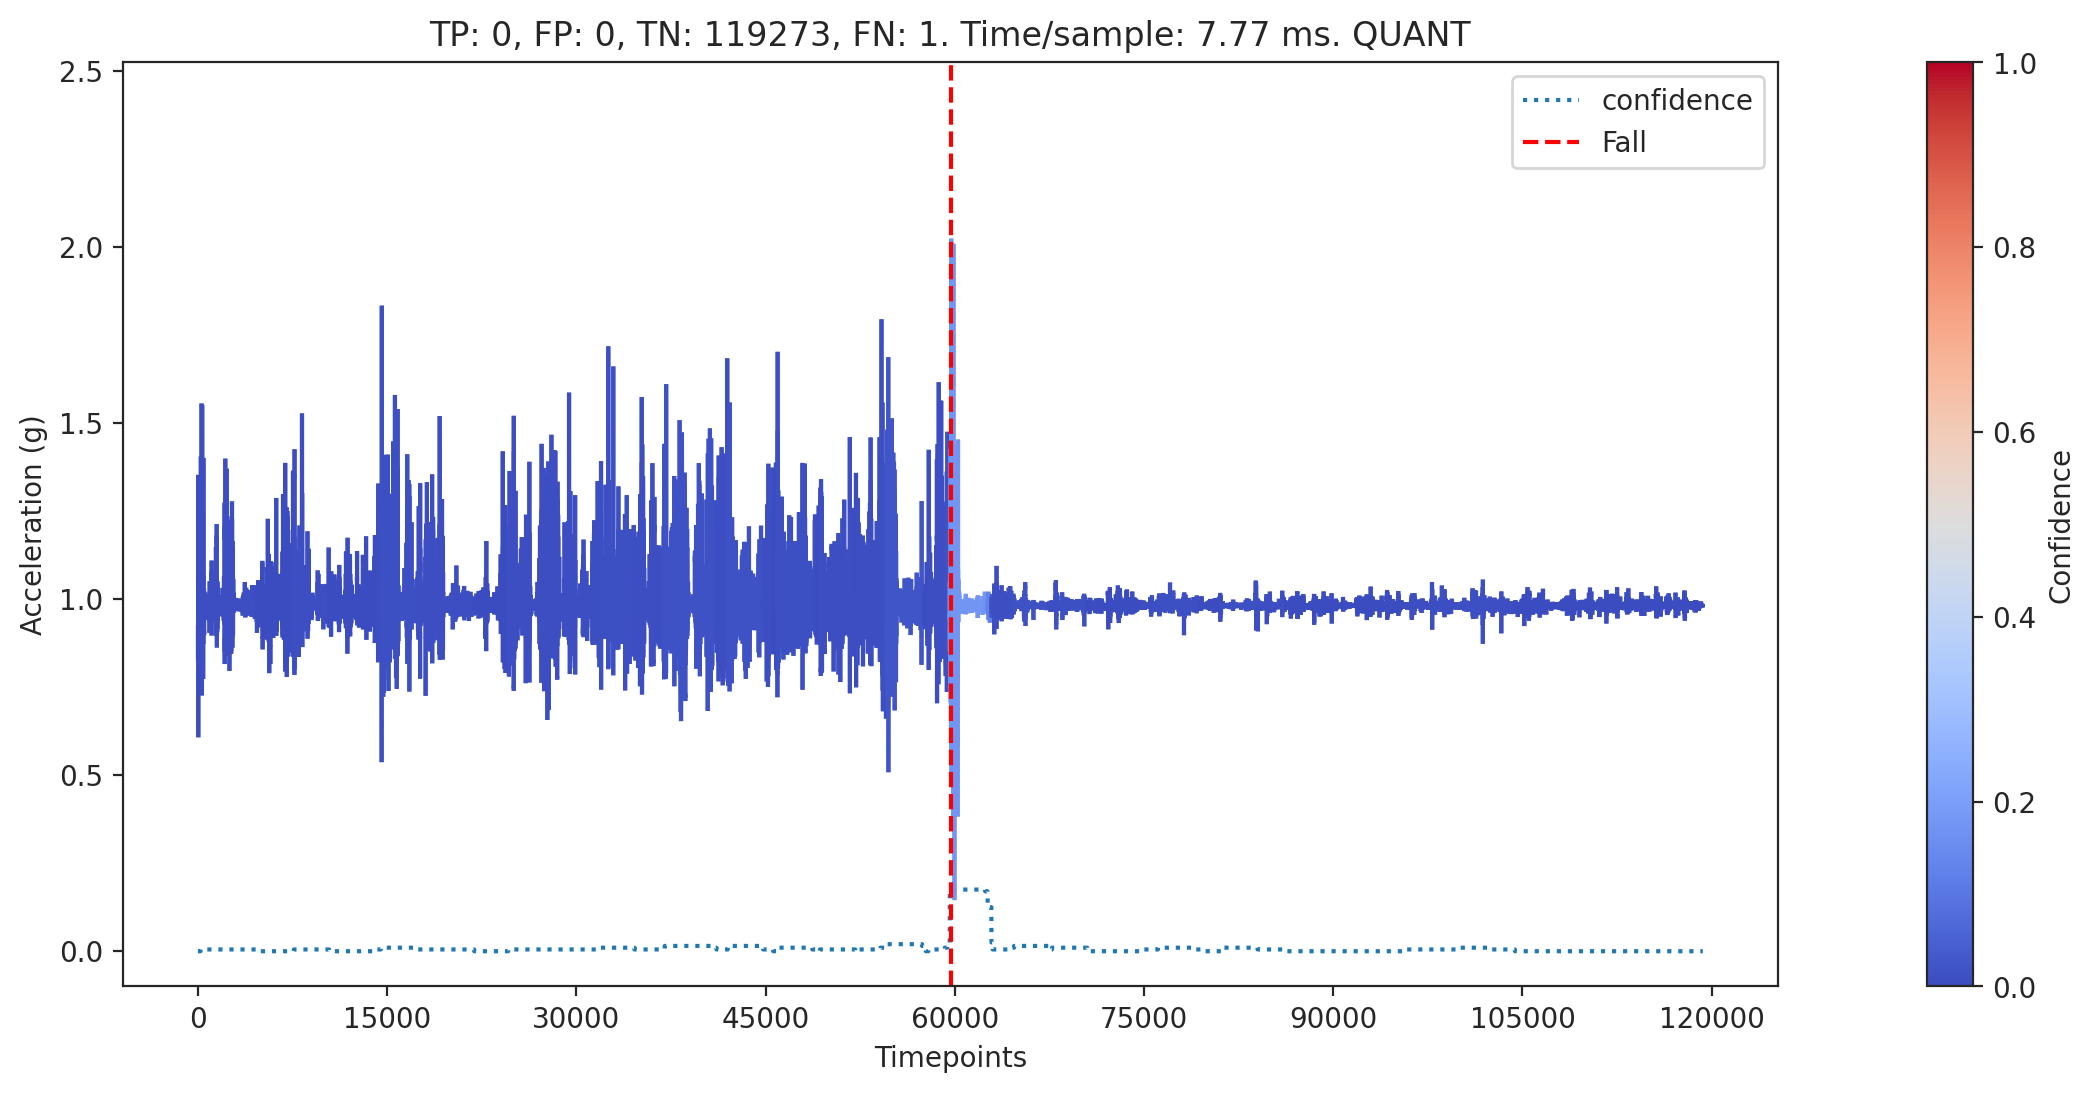

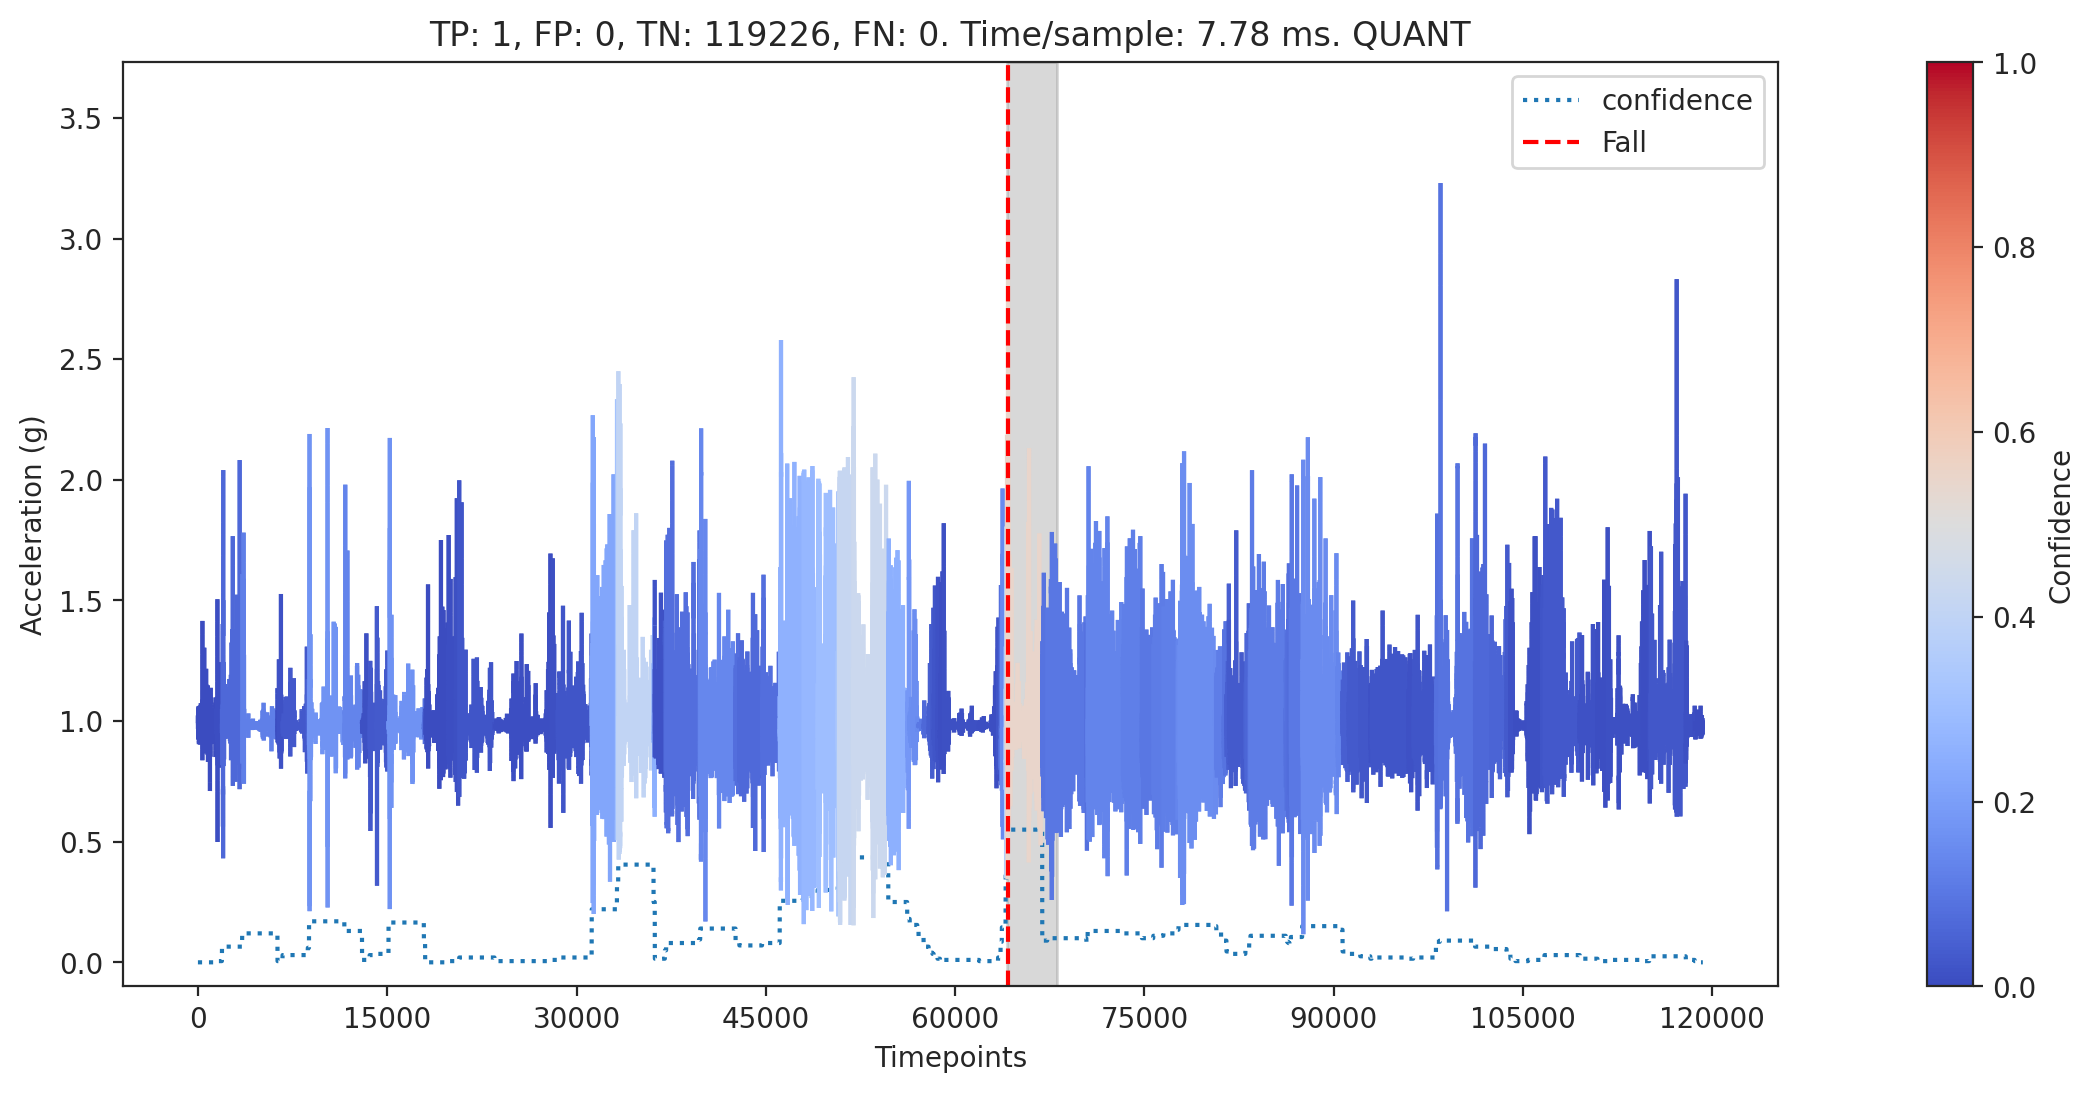

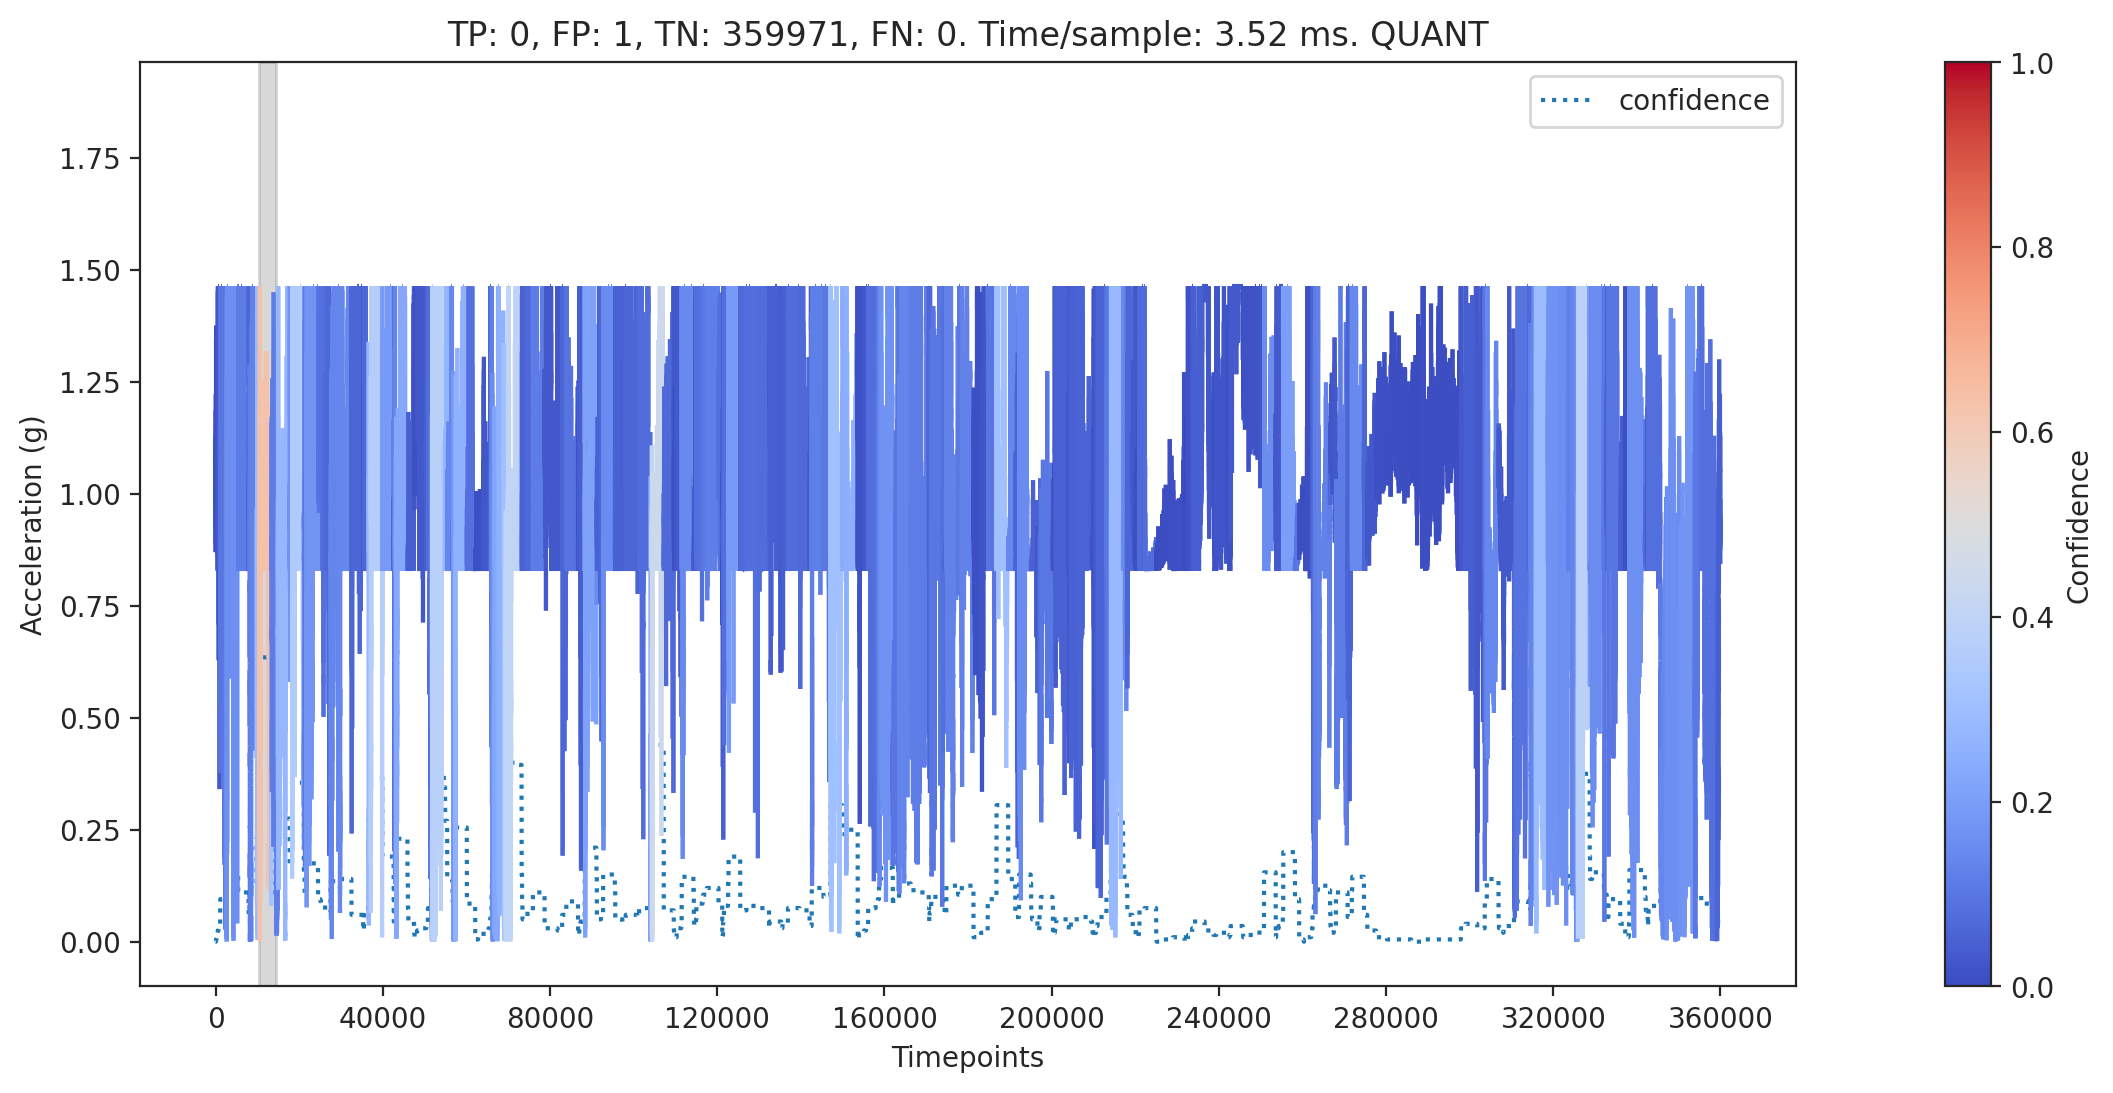

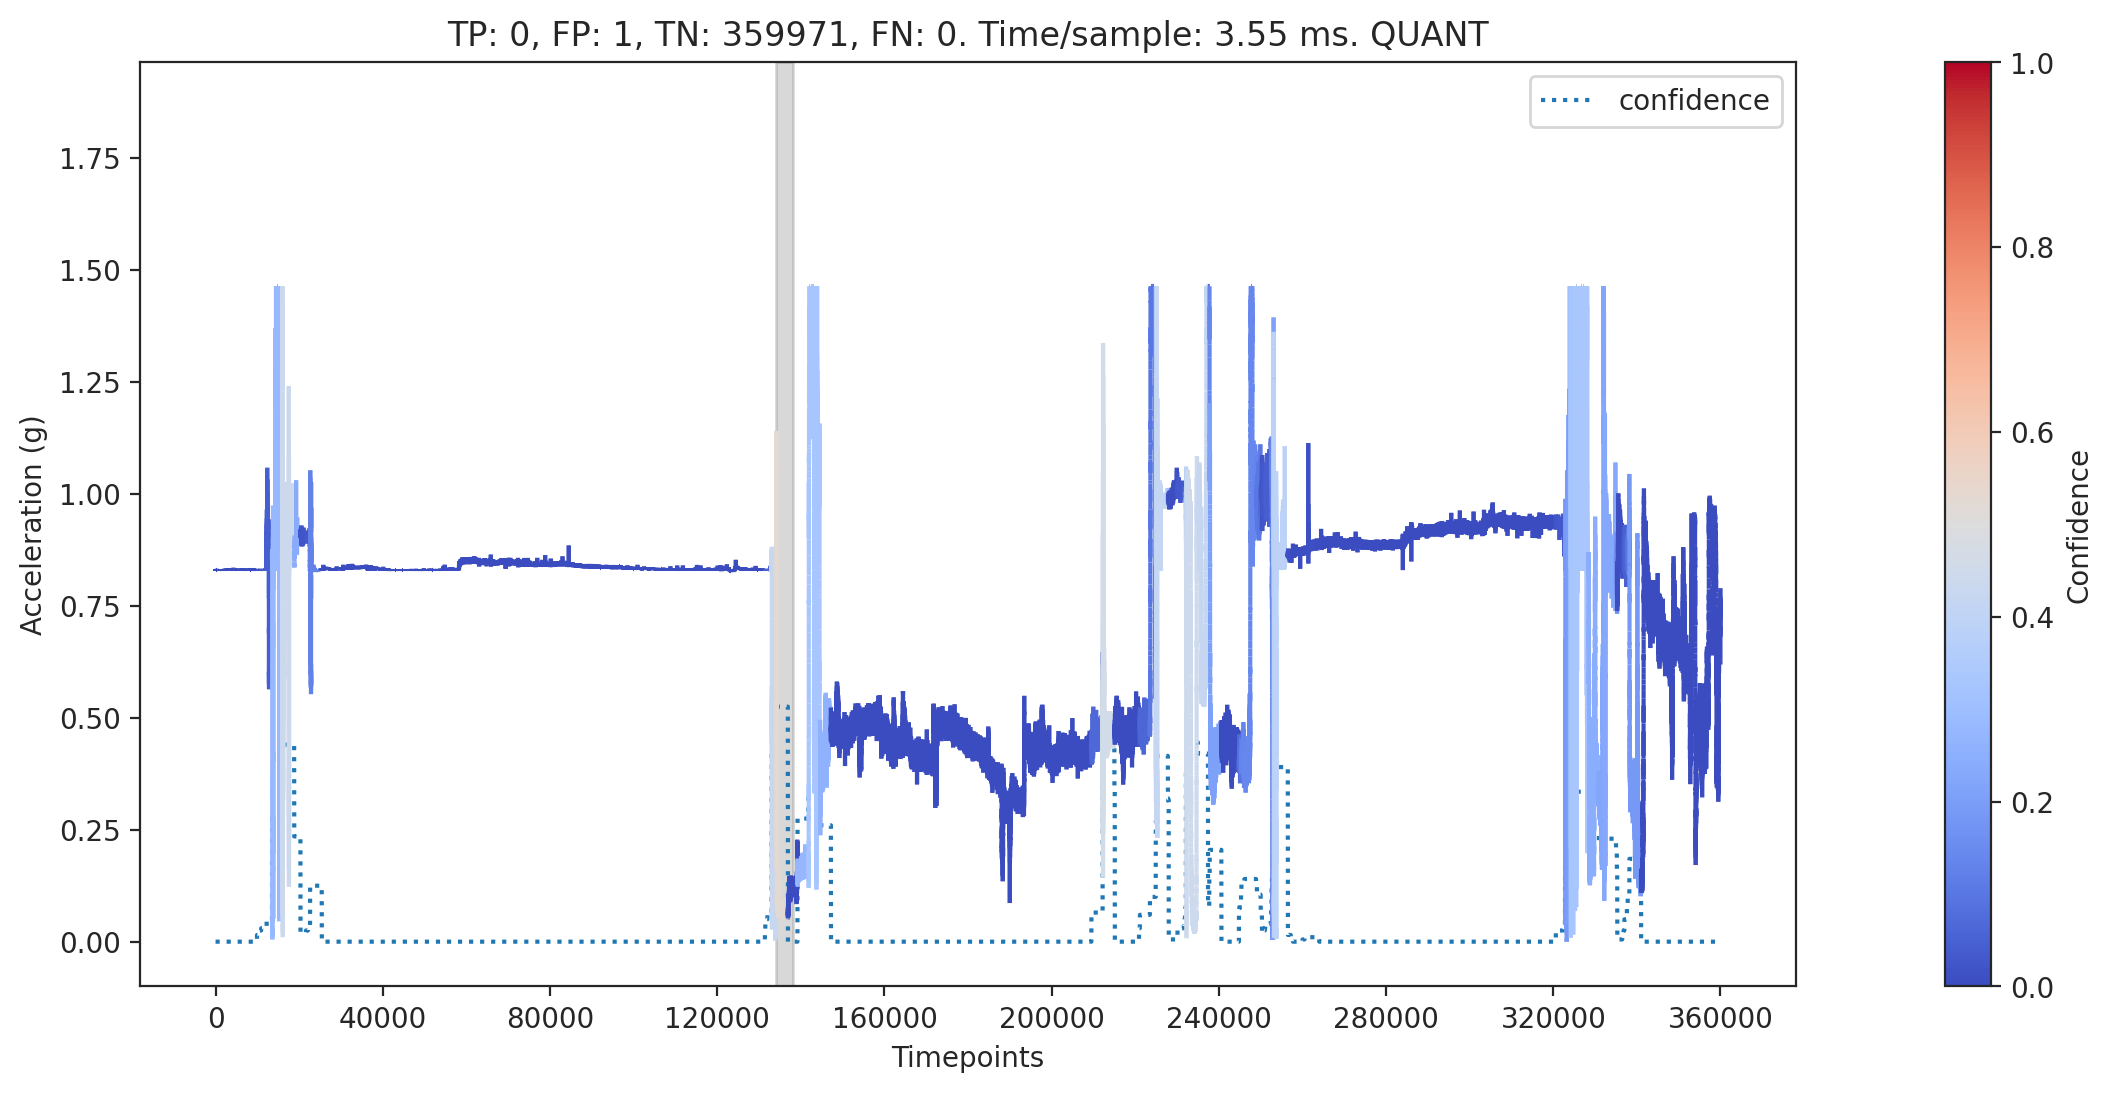

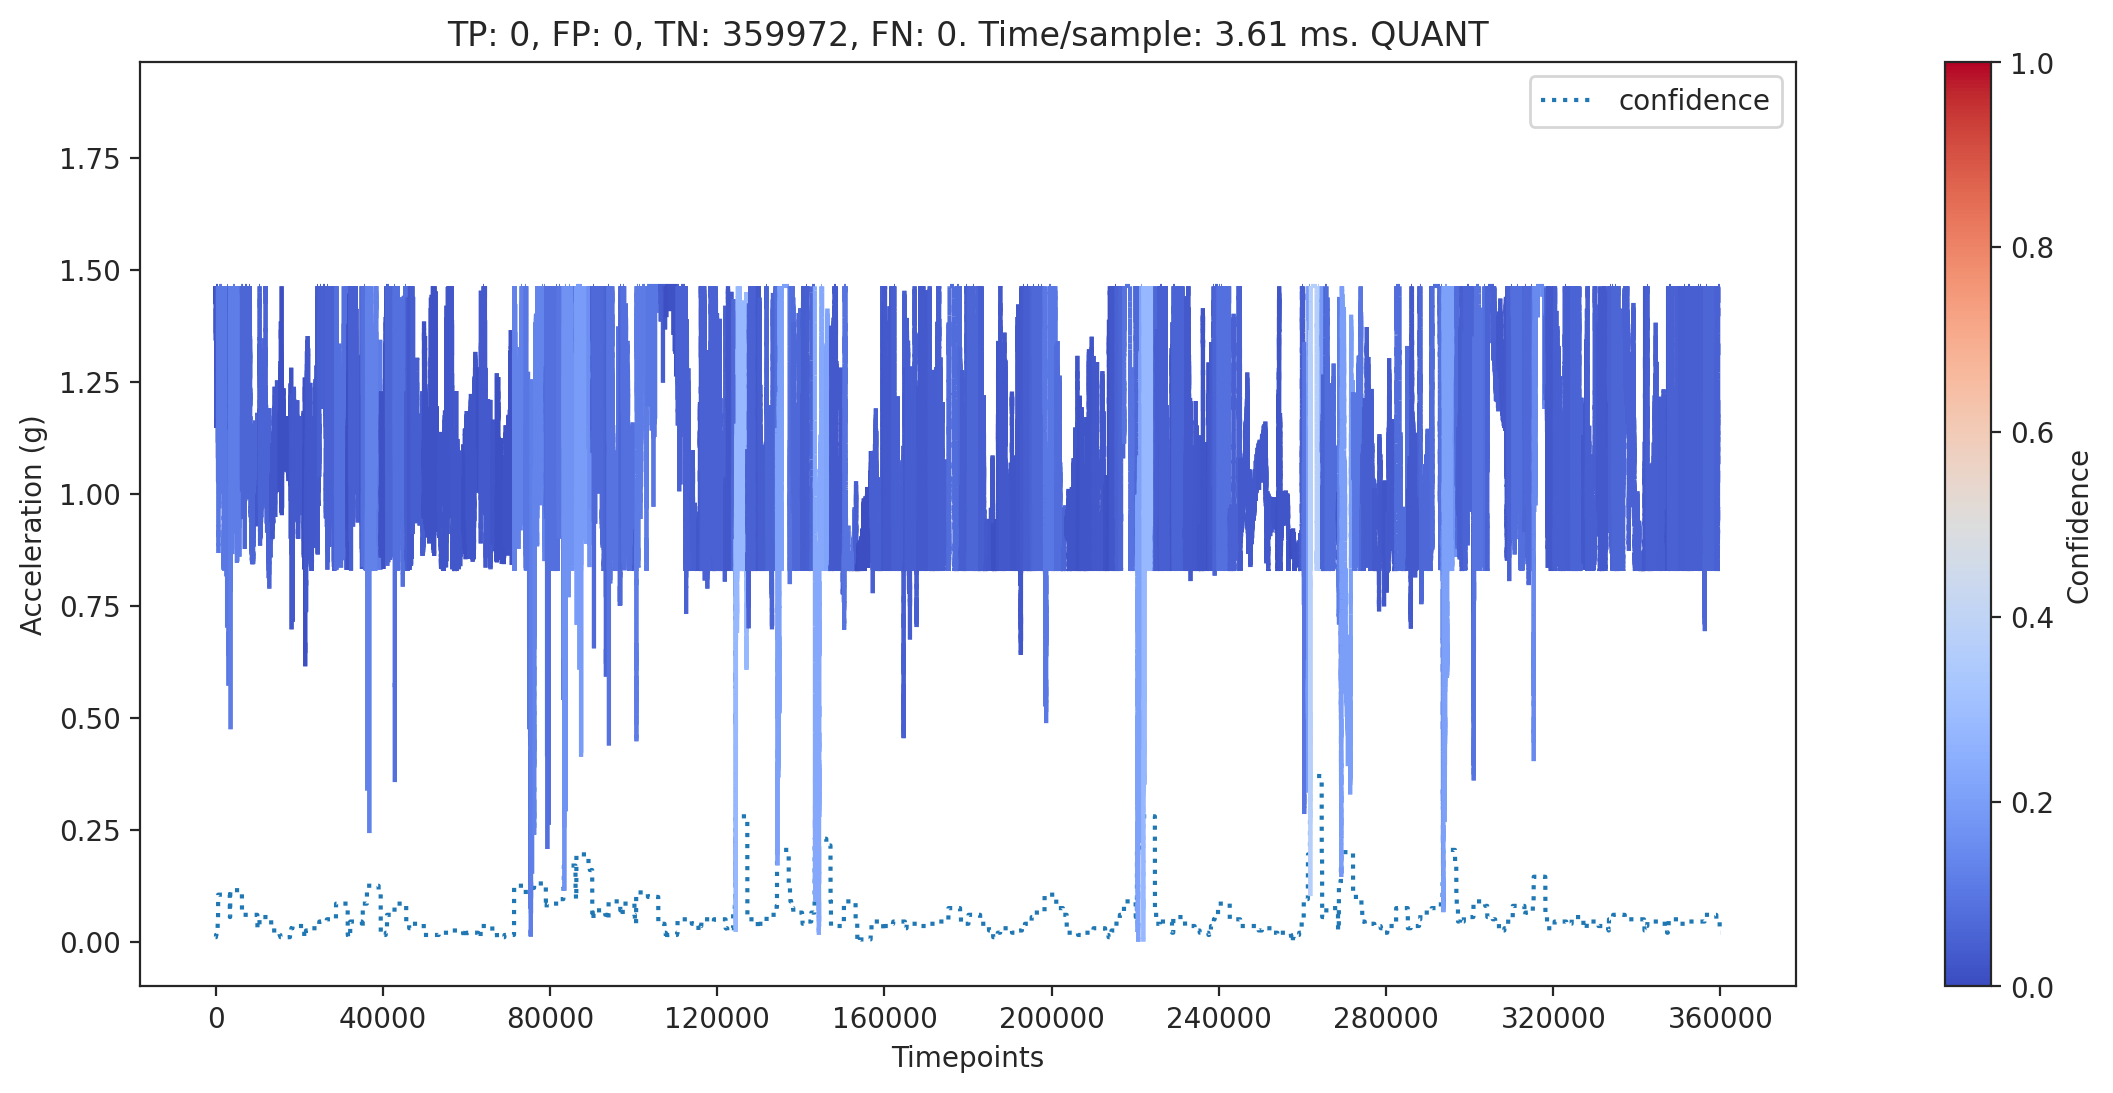

. Ensemble. ✅


/mnt/storage/timiderinola/home/insight/msca/fall_probs_ecml/scripts/utils.py:430: RuntimeWarning: invalid value encountered in scalar divide
  gain = classifiers.cost_fn(cm=cm, **kwargs) / (n_samples * 1000)
/mnt/storage/timiderinola/miniconda3/envs/msca/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/storage/timiderinola/miniconda3/envs/msca/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [92]:
kwargs['saved_models'] = 'models/full_farseeing_trained_quant_w40_t160.joblib'
adl_metrics_df = classifiers.run_models(X, X_test, y, y_test, **kwargs)

In [93]:
adl_metrics_df

,model,window_size,runtime,auc,precision,recall,specificity,f1-score,false alarm rate,miss rate,delay,g
0,QUANT,28,3.614017,0.833333,0.5,0.666667,0.999999,0.571429,0.50076,0.25038,26.353333,0.001
1,Ensemble,28,3.614017,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,NaN,NaN
